# Pairs Trading

Pairs trading is a form of mean-reversion quantitative strategy. In pairs trading, there are two different different equities that are traded and have a very high correlation value associated with each other. The assumption here is that these two equities have a stationary value where they will converge to whenever they begin to diverge. When these equities begin converging to this stationary value, trades are executed related to a short or long position.

Importing packages and retrieving 1 year of stock data using `yfinance`.

In [46]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller


In [24]:
def get_data(tickers):
    data = pd.DataFrame()
    names = list()

    for tick in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(tick, start=datetime(2022, 10, 27), end=datetime(2023, 10, 27)).iloc[:,4])], axis = 1)
        names.append(tick)

    data.columns = names
    return data

tickers = ["AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX","AMZN", "BA", "WMT","CMG","GS","XOM","NKE","INTC", "META","BRK-B", "MSFT"] 
stock_data = get_data(tickers)

stock_data.tail()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,AAPL,GOOG,AMD,GME,SPY,NFLX,AMZN,BA,WMT,CMG,GS,XOM,NKE,INTC,META,BRK-B,MSFT
Date,,,,,,,,,,,,,,,,,
2023-10-20,171.999863,136.405014,101.809998,13.44,416.845093,400.959991,125.169998,180.039993,52.215137,36.625000,292.006958,107.317192,101.113297,34.345562,308.017029,335.859985,324.236298
2023-10-23,172.119247,137.562164,100.010002,13.44,416.122620,406.839996,126.559998,181.029999,52.955143,36.393200,291.199249,105.742409,101.251167,33.293171,313.366058,336.839996,326.866516
2023-10-24,172.557007,139.776733,101.669998,14.04,419.259949,413.730011,128.559998,182.360001,53.691868,37.101799,291.160309,104.718315,103.585236,34.021000,311.909027,338.630005,328.067505
2023-10-25,170.228912,126.359680,96.059998,13.71,413.242615,411.250000,121.389999,177.729996,53.530708,36.837399,288.805176,104.911552,101.970100,32.289951,298.915741,336.899994,338.131958
2023-10-26,166.040359,123.137604,93.669998,13.50,408.294220,403.540009,119.570000,179.089996,53.205105,36.129398,289.028992,103.955078,98.503479,31.985046,287.758667,336.160004,325.447205


Next, we need to find the correlations between all of the pairs in our data.

In [6]:
correlation_matrix = stock_data.corr()
correlation_matrix

,AAPL,GOOG,AMD,GME,SPY,NFLX,AMZN,BA,WMT,CMG,GS,XOM,NKE,INTC,META,BRK-B,MSFT
AAPL,1.000000,0.868021,0.926885,-0.040056,0.923061,0.849538,0.901260,0.489047,0.774860,0.914949,-0.449356,-0.043326,-0.331529,0.794059,0.921944,0.788830,0.959371
GOOG,0.868021,1.000000,0.850978,-0.314211,0.900151,0.812996,0.951157,0.396521,0.890566,0.783993,-0.487351,0.144000,-0.500188,0.898312,0.934049,0.903245,0.917446
AMD,0.926885,0.850978,1.000000,-0.074643,0.869305,0.847477,0.858700,0.589583,0.679043,0.885239,-0.490715,-0.108925,-0.232427,0.741423,0.910948,0.729732,0.943149
GME,-0.040056,-0.314211,-0.074643,1.000000,-0.167231,-0.112100,-0.207234,-0.192251,-0.293026,-0.000783,0.431301,-0.308912,0.023417,-0.262902,-0.368922,-0.352351,-0.194852
SPY,0.923061,0.900151,0.869305,-0.167231,1.000000,0.932366,0.950676,0.617639,0.861746,0.824189,-0.276935,0.104271,-0.332360,0.872356,0.922222,0.921360,0.922689
NFLX,0.849538,0.812996,0.847477,-0.112100,0.932366,1.000000,0.897203,0.655303,0.745678,0.789582,-0.305061,-0.005493,-0.261513,0.775985,0.854278,0.824269,0.865251
AMZN,0.901260,0.951157,0.858700,-0.207234,0.950676,0.897203,1.000000,0.478082,0.868844,0.805317,-0.405372,0.106875,-0.493786,0.887293,0.926514,0.918348,0.917078
BA,0.489047,0.396521,0.589583,-0.192251,0.617639,0.655303,0.478082,1.000000,0.322335,0.484419,-0.092206,0.038069,0.331933,0.385548,0.554667,0.512422,0.503143
WMT,0.774860,0.890566,0.679043,-0.293026,0.861746,0.745678,0.868844,0.322335,1.000000,0.685590,-0.314461,0.249897,-0.515586,0.891206,0.825030,0.931949,0.823150
CMG,0.914949,0.783993,0.885239,-0.000783,0.824189,0.789582,0.805317,0.484419,0.685590,1.000000,-0.458591,-0.087038,-0.157777,0.665407,0.844292,0.707465,0.926793


Use a heatmap to eaier visualise correlations (lighter colours = higher correlation), our aim here is to find values very close to 1 (>0.85).

<Axes: >

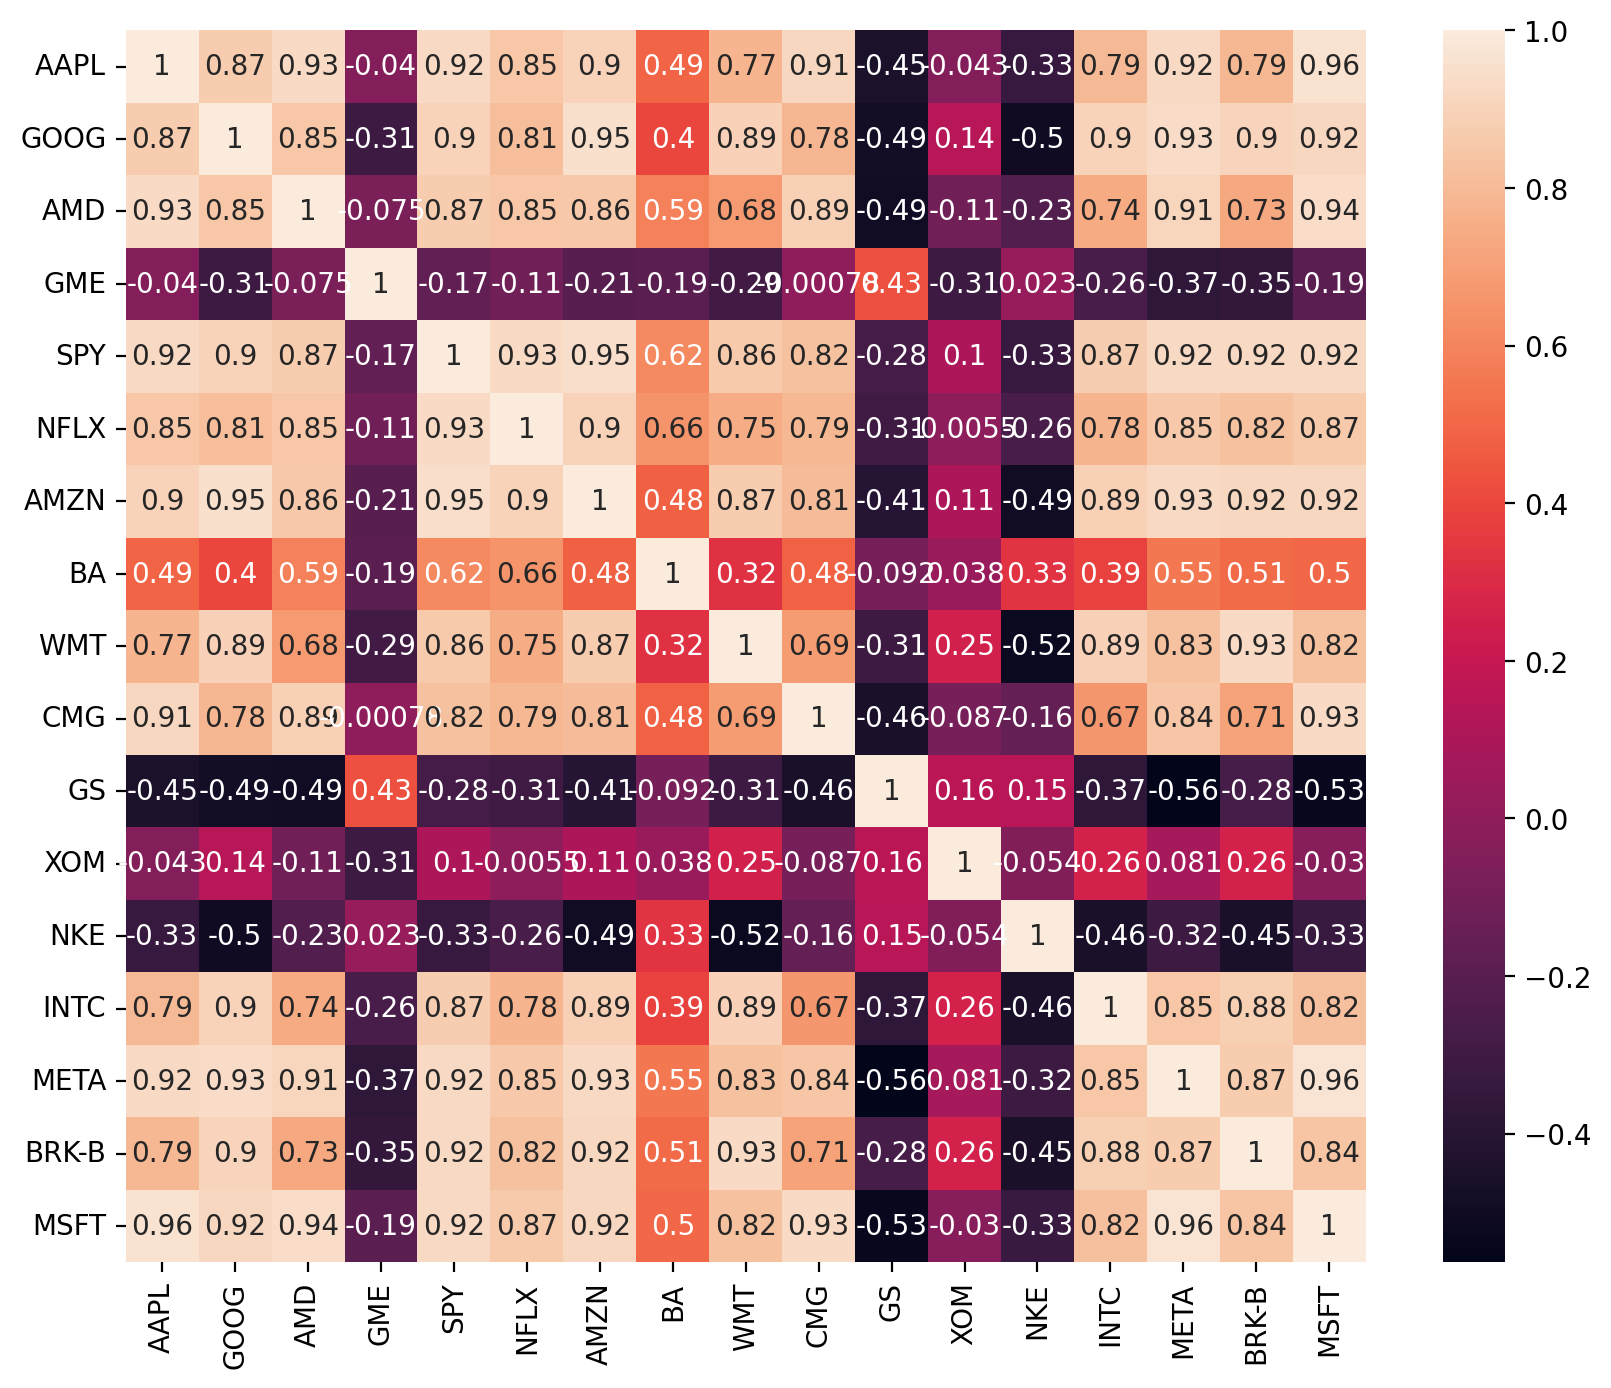

In [10]:
figure(figsize=(10, 8), dpi=200)
sns.heatmap(correlation_matrix, annot = True)

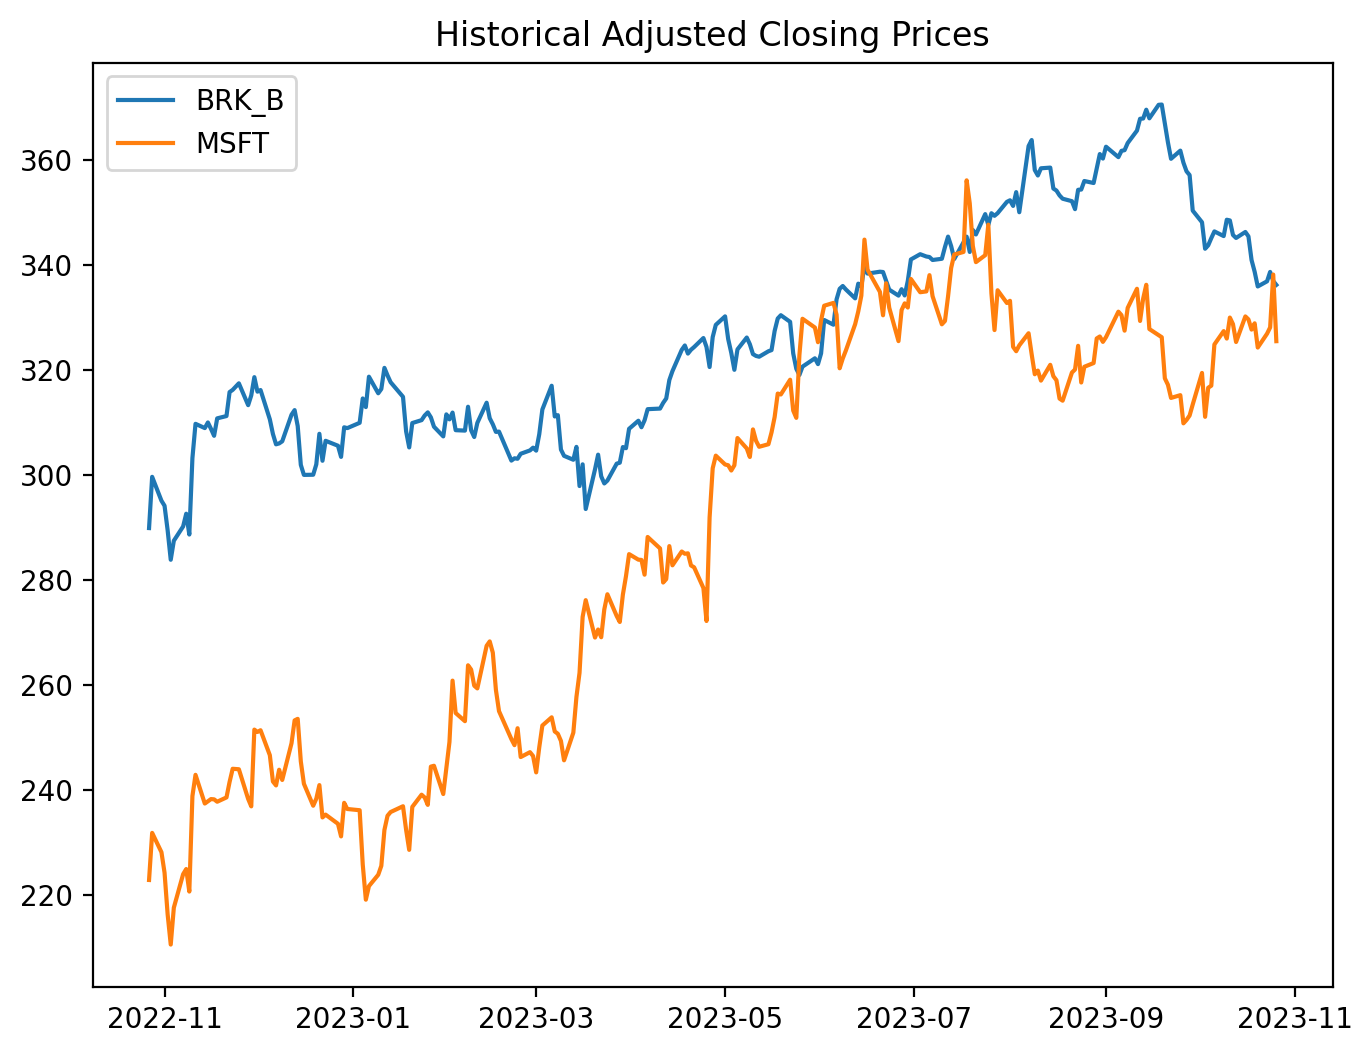

In [41]:
figure(figsize=(8, 6), dpi=200)
BRKB = stock_data['BRK-B']
MSFT = stock_data['MSFT']
plt.plot(BRKB, label = "BRK_B")
plt.plot(MSFT, label = "MSFT")
plt.title('Historical Adjusted Closing Prices')
plt.legend()

In an ideal scenario, you would want these two stocks to be diverging to further capaitilse on short/long positions. In the above figure the assets are 'kinda' moving in opposite directions

Text(0.5, 1.0, 'Spread between BRK-B and MSFT')

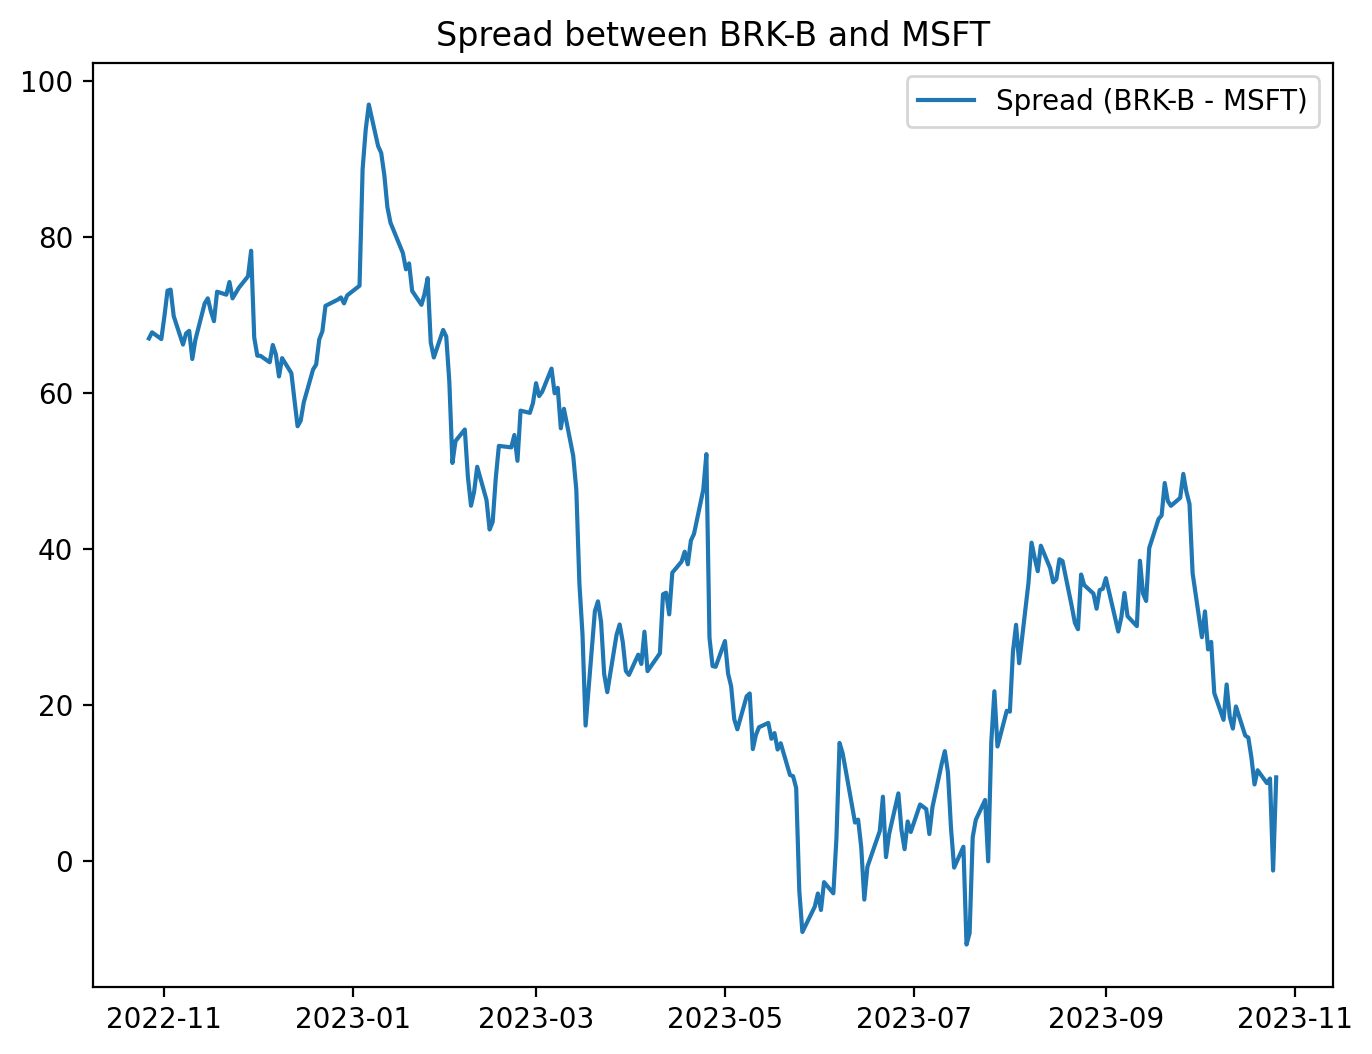

In [42]:
figure(figsize=(8, 6), dpi=200)
plt.plot(BRKB - MSFT, label = 'Spread (BRK-B - MSFT)')
plt.legend()
plt.title("Spread between BRK-B and MSFT")

Now we can try to find the stationary points of these two assets. We first check the [cointegration](https://en.wikipedia.org/wiki/Cointegration#Engle–Granger_two-step_method) value; null hypotheses = there is no cointegration

The cointegration test is a method used to find a potential correlation in a long time series. In this context, we are trying to determine if there is a constant spread betweeen these two assets over time. Here we use the Engle-Granger two-step cointegration test. Ideally, we want our p-value to <0.5 to prove that cointegration exists.

In [45]:
coint = ts.coint(BRKB, MSFT)[0]
p_val = ts.coint(BRKB, MSFT)[1]
crit_values = ts.coint(BRKB, MSFT)[2]

print('p_value: ', p_val)

p_value:  0.4494893227233074


We also conduct the [ADF test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test). We can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.

In [47]:
Spread_ADF = adfuller(BRKB - MSFT)
print('P value of spread for ADF Test: ', Spread_ADF[1])
Ratio_ADF = adfuller(BRKB / MSFT)
print('P value of ratio for ADF Test: ', Ratio_ADF[1])


P value of spread for ADF Test:  0.3652252017417751
P value of ratio for ADF Test:  0.5383125499482428


Spread looks fine - the two series are cointegrated. We can visualise the ratios below.

Text(0.5, 1.0, 'Price Ratio between BRK and MSFT')

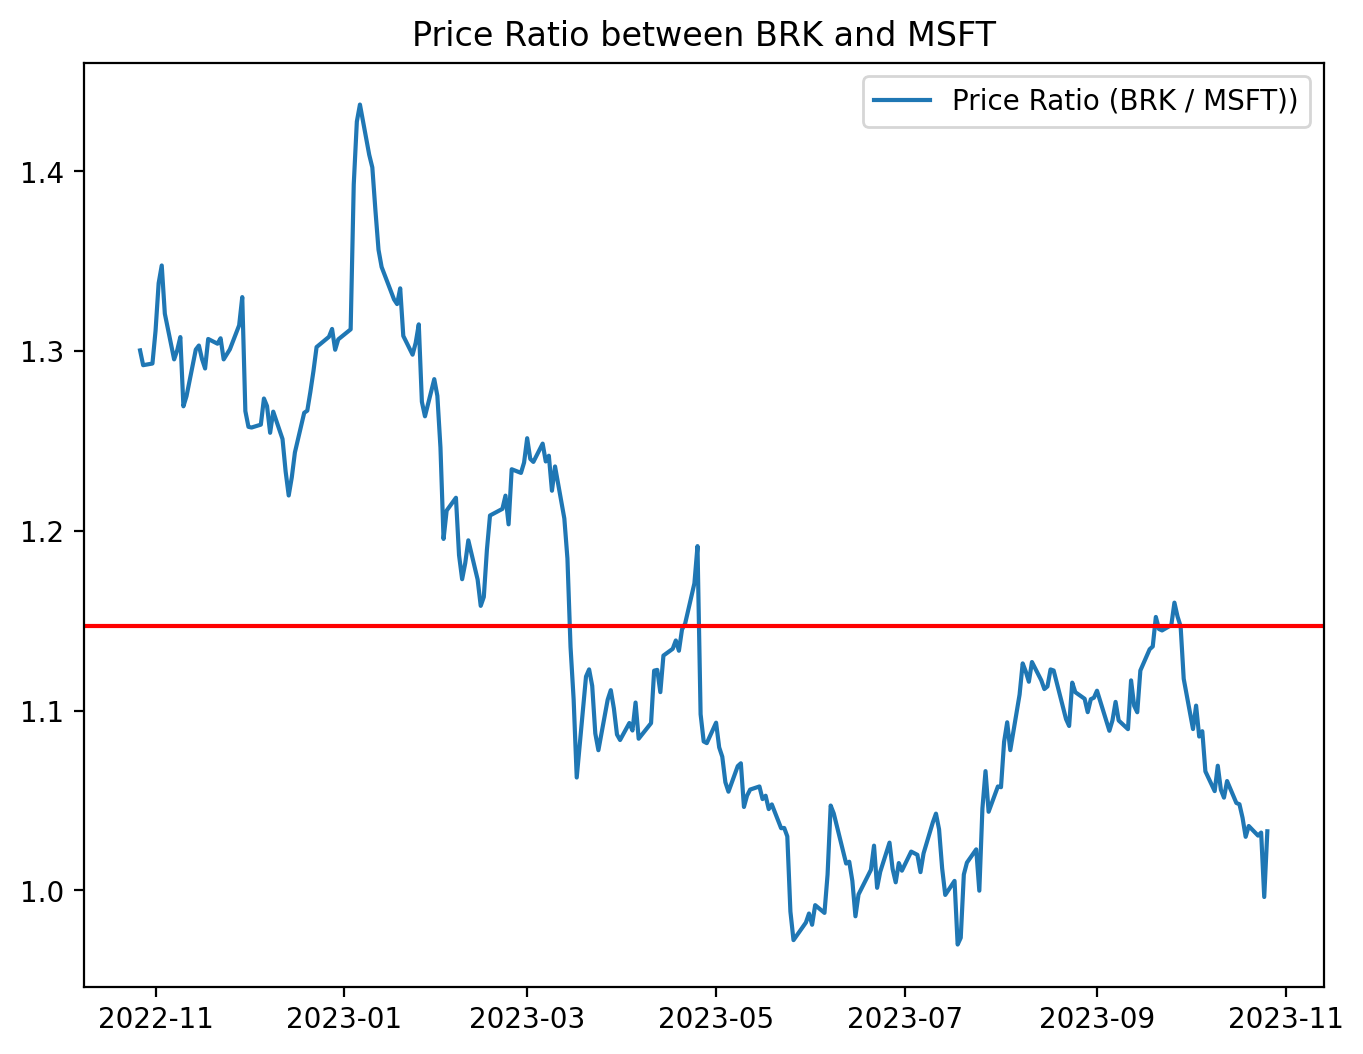

In [48]:
figure(figsize=(8, 6), dpi=200)
ratio = BRKB / MSFT
plt.plot(ratio, label = 'Price Ratio (BRK / MSFT))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between BRK and MSFT")

Lets calculate z-scores to set our upper and lower limits. The range that exists outside of these limits must come converge back to the mean. So now we can determine when we can long or short the pair (BRK_B to MSFT).

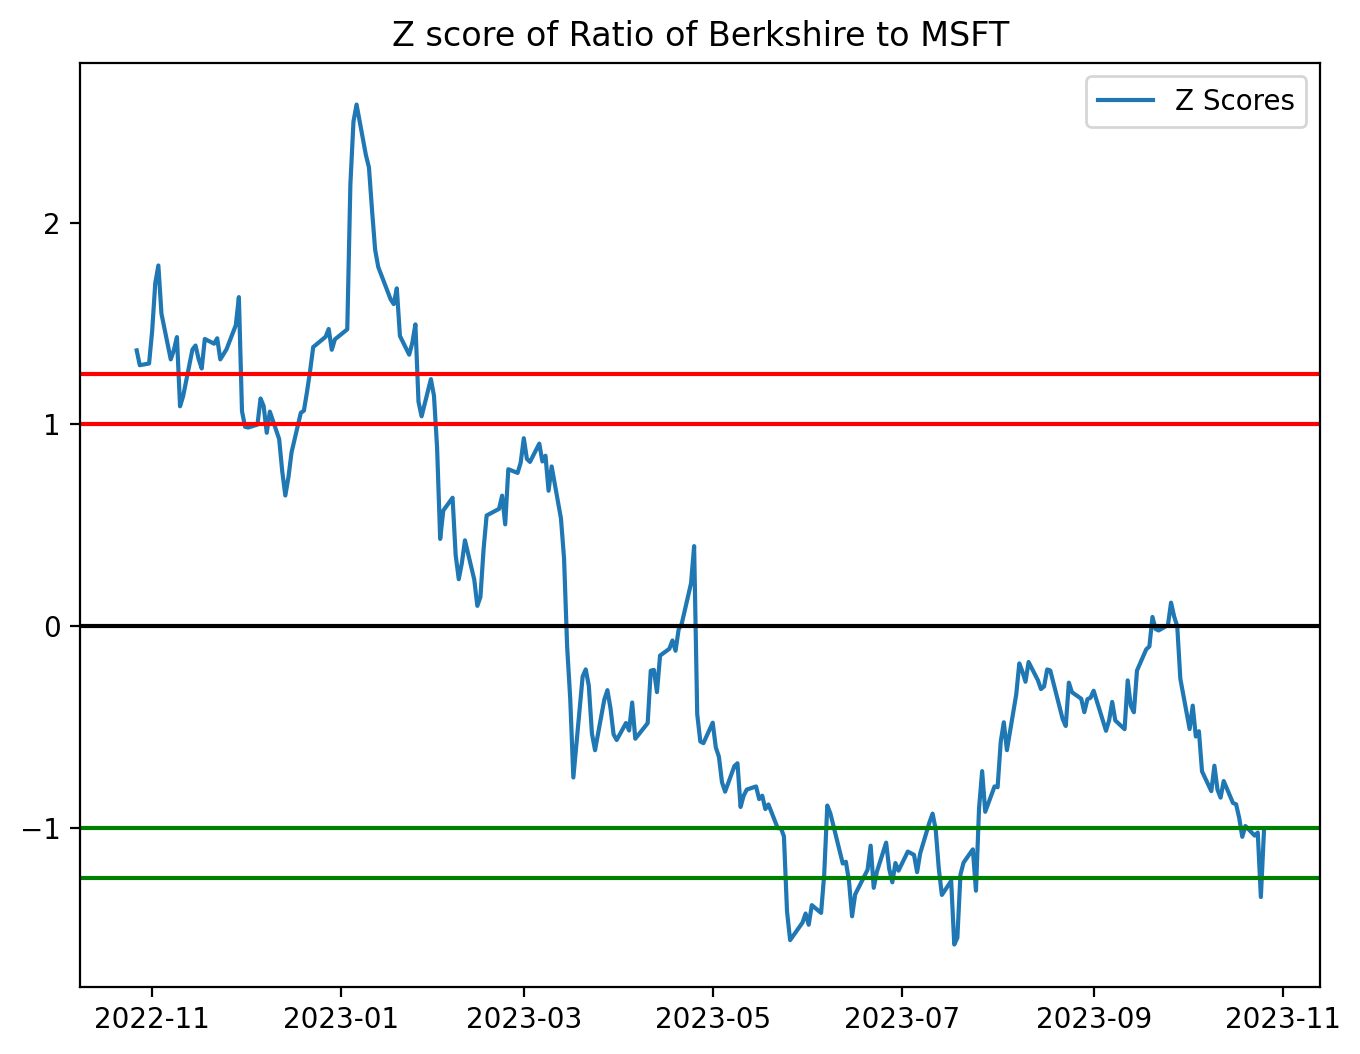

In [49]:
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of Berkshire to MSFT')
plt.show()

Now we need some sort of signal to tell us when we should start trading these stocks. This is where we use probability and simple ML models to determine when we should long/short the pair. Here we calculate the moving average of these two stocks over 5 days and 20 days.

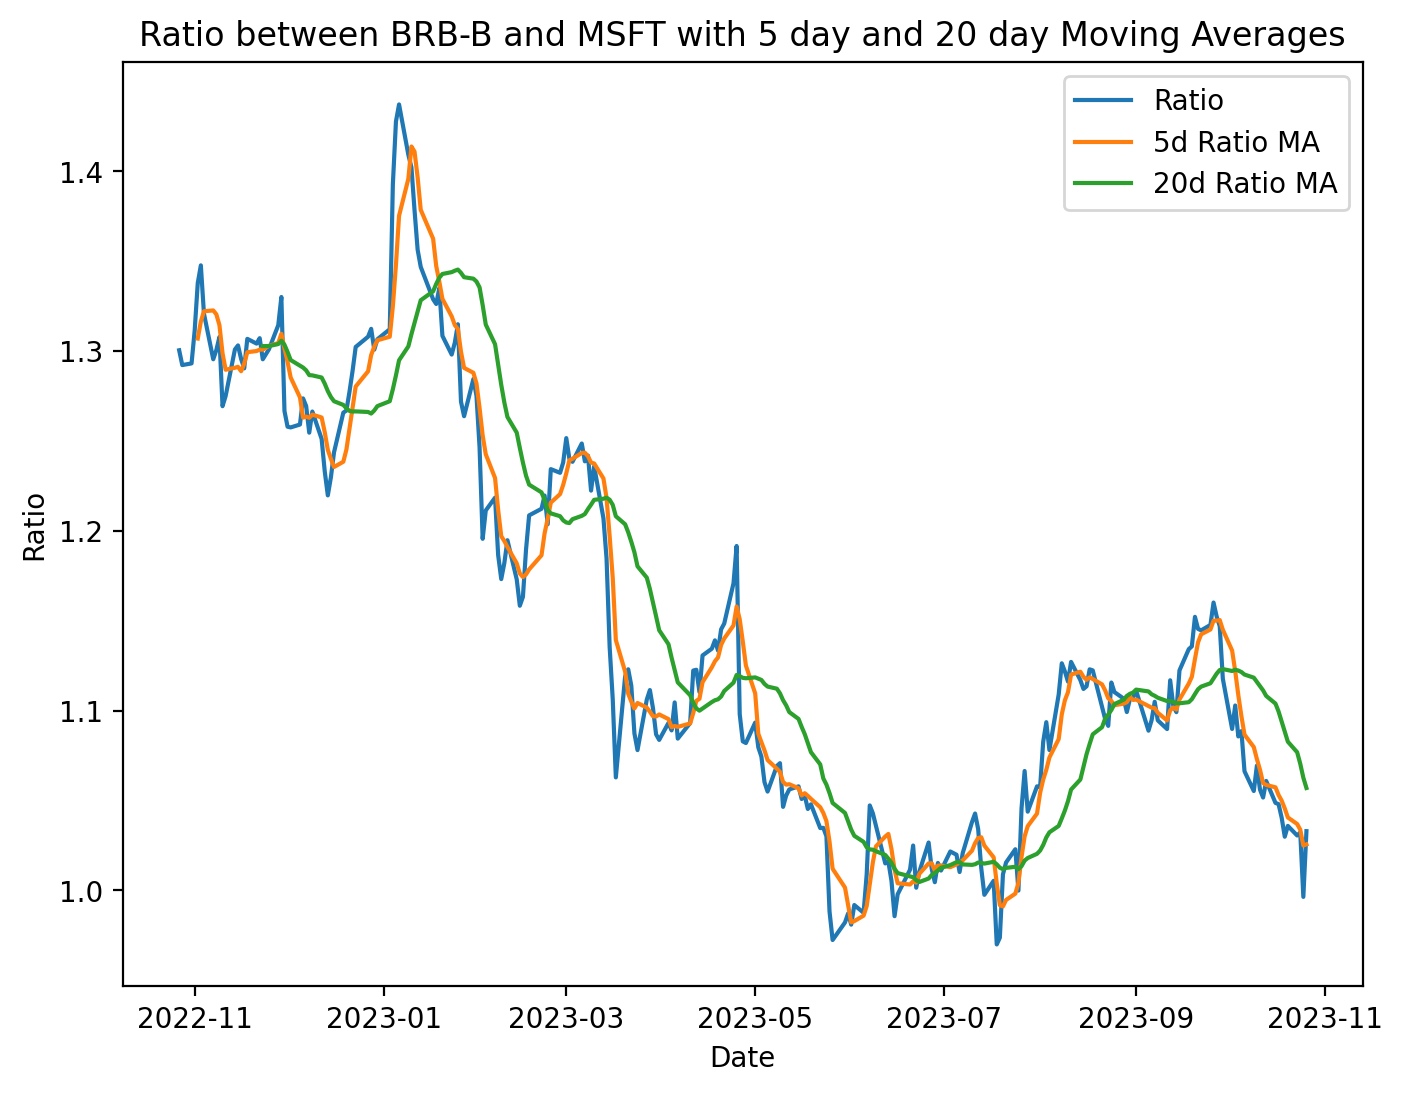

In [50]:
figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between BRB-B and MSFT with 5 day and 20 day Moving Averages')
plt.show()

Again, we plot the zscore for these moving averages.

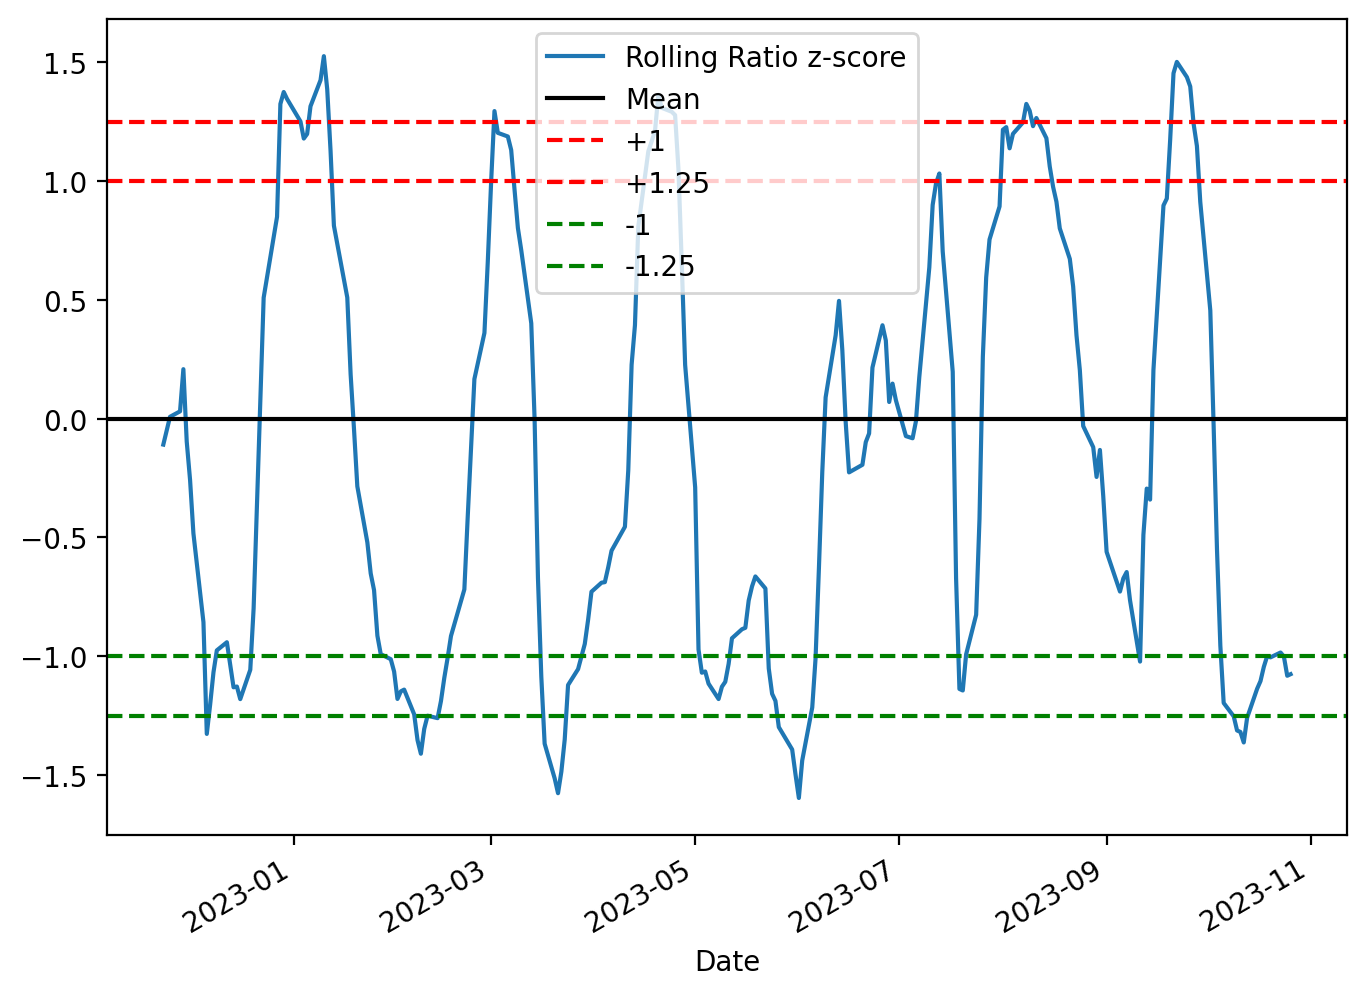

In [51]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

Whenever our points fall inside (and especially) outside of our bounds, we want to buy/sell the relationship between Berkshire to Microsoft. 

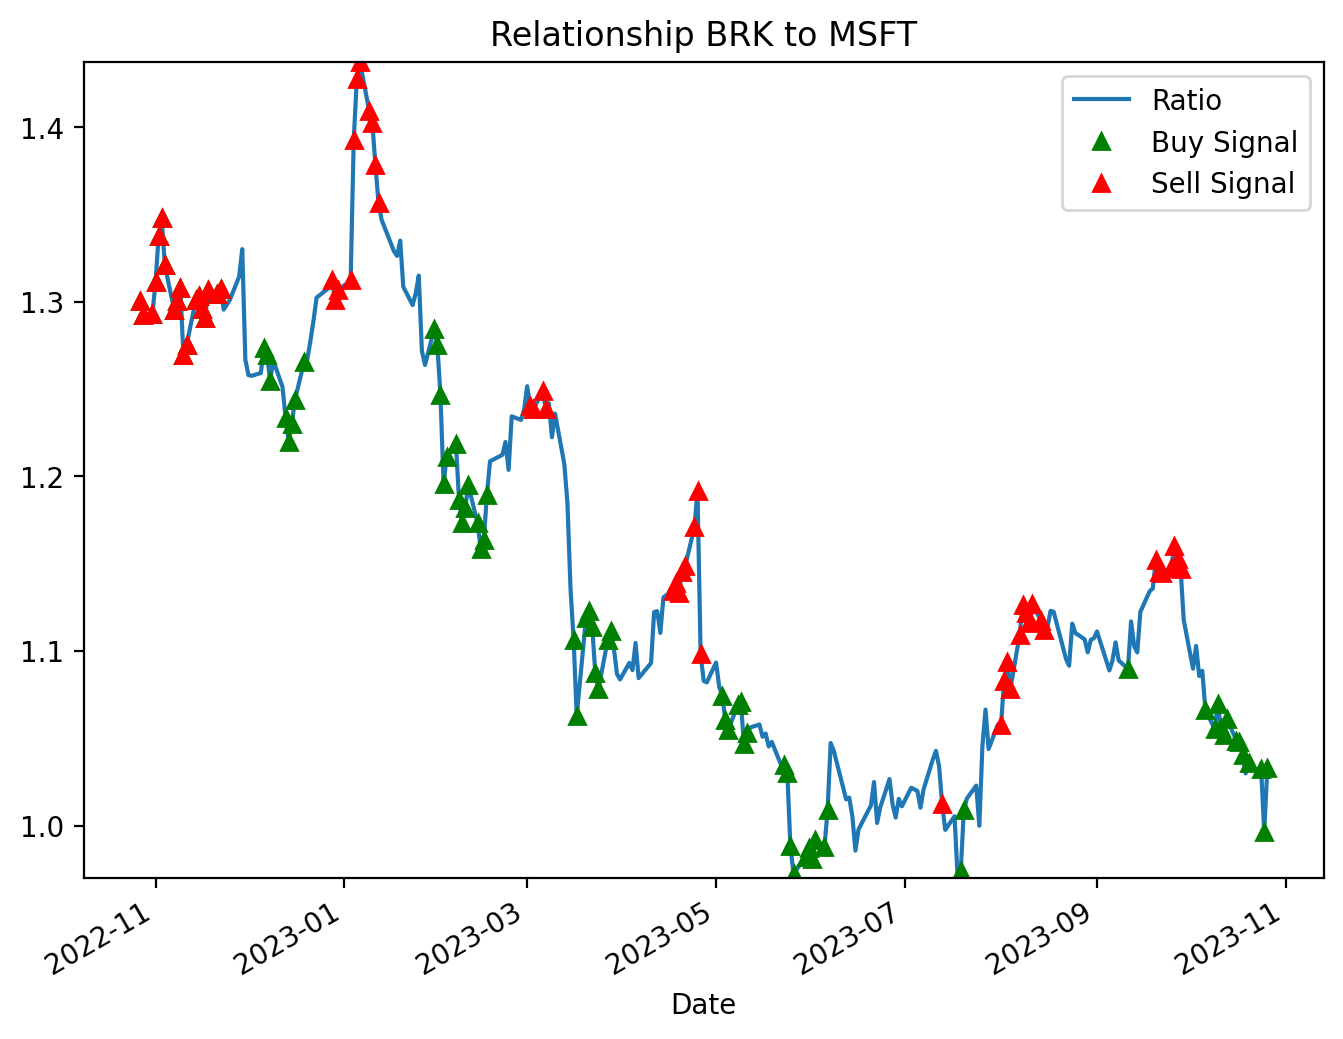

In [52]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')
plt.show()